In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2

In [5]:
import zipfile
local_zip = '//content/archive (2).zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

(384, 512, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

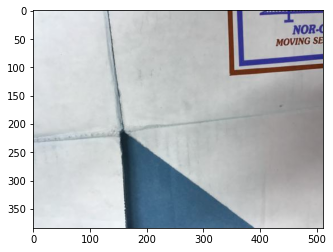

In [8]:
img = cv2.imread('/content/garbage classification/Garbage classification/cardboard/cardboard100.jpg')
print(img.shape)
plt.imshow(img)
plt.show

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 350
CHANNELS=3
EPOCHS=50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/garbage classification/Garbage classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2527 files belonging to 6 classes.


In [10]:
class_names = dataset.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 350, 350, 3)
[4 0 2 0 0 3 3 3 2 3 1 1 3 3 3 0 2 2 4 3 4 4 1 2 3 3 0 4 2 2 3 4]


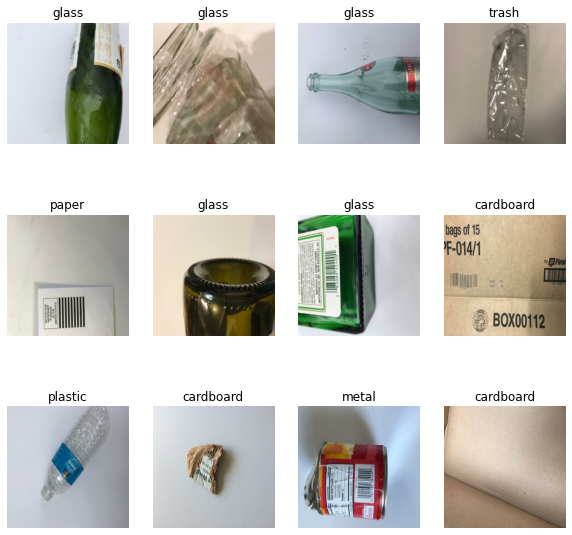

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
print(len(train_ds),len(val_ds),len(test_ds ))

63 7 9


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 350, 350, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 348, 348, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 174, 174, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 172, 172, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 86, 86, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 84, 84, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
63/63 [==============================] - 53s 547ms/step - loss: 1.7185 - accuracy: 0.2465 - val_loss: 1.5639 - val_accuracy: 0.4062
Epoch 2/50
63/63 [==============================] - 27s 421ms/step - loss: 1.5789 - accuracy: 0.3477 - val_loss: 1.4012 - val_accuracy: 0.4375
Epoch 3/50
63/63 [==============================] - 26s 412ms/step - loss: 1.4728 - accuracy: 0.3909 - val_loss: 1.3631 - val_accuracy: 0.4643
Epoch 4/50
63/63 [==============================] - 26s 410ms/step - loss: 1.4863 - accuracy: 0.3884 - val_loss: 1.3488 - val_accuracy: 0.4420
Epoch 5/50
63/63 [==============================] - 26s 412ms/step - loss: 1.4281 - accuracy: 0.4231 - val_loss: 1.4440 - val_accuracy: 0.3795
Epoch 6/50
63/63 [==============================] - 27s 425ms/step - loss: 1.3463 - accuracy: 0.4514 - val_loss: 1.2137 - val_accuracy: 0.4821
Epoch 7/50
63/63 [==============================] - 26s 411ms/step - loss: 1.2766 - accuracy: 0.5010 - val_loss: 1.2953 - val_accuracy: 0.4911

In [24]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 7s 46ms/step - loss: 0.4179 - accuracy: 0.8819


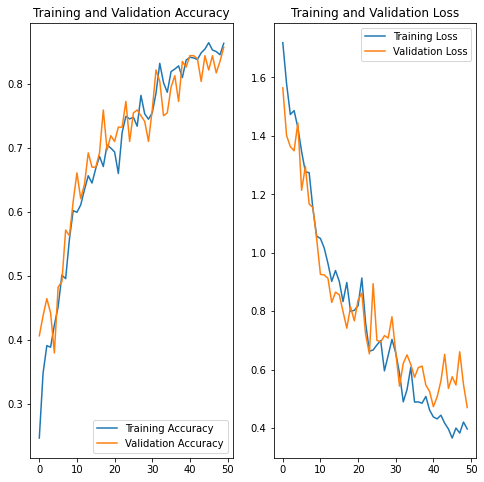

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: paper
1/1 [==============================] - 1s 1s/step
predicted label: paper


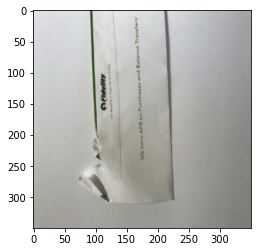

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [45]:
def y_predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    y_pred = np.argmax(predictions[0])

    return y_pred


1/1 [==============================] - 0s 20ms/step


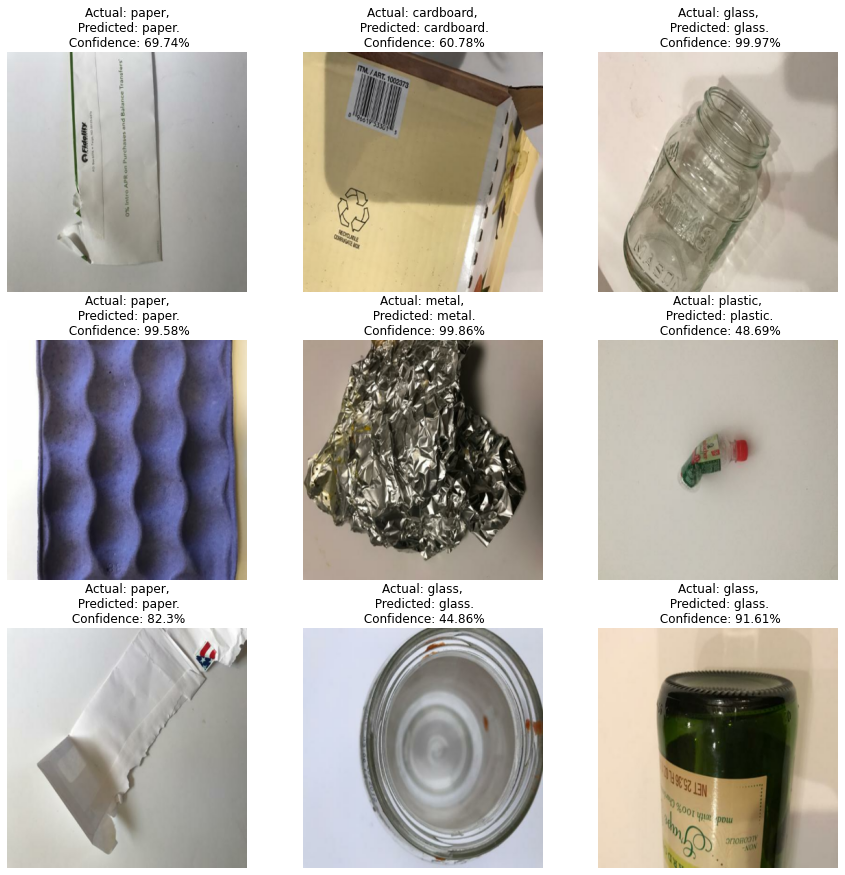

In [49]:
y_true = []
prediction =[]
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        y_pred= y_predict(model, images[i].numpy())
        y_true.append(labels)
        prediction.append(y_pred)
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [48]:
y_true

[<tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 0, 3, 4, 2, 5, 1, 1, 2, 0, 3, 4, 1, 3, 0, 0, 2, 3, 3, 3, 0, 0,
        0, 5, 2, 2, 0, 4, 3, 4, 3, 2], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 0, 3, 4, 2, 5, 1, 1, 2, 0, 3, 4, 1, 3, 0, 0, 2, 3, 3, 3, 0, 0,
        0, 5, 2, 2, 0, 4, 3, 4, 3, 2], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 0, 3, 4, 2, 5, 1, 1, 2, 0, 3, 4, 1, 3, 0, 0, 2, 3, 3, 3, 0, 0,
        0, 5, 2, 2, 0, 4, 3, 4, 3, 2], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 0, 3, 4, 2, 5, 1, 1, 2, 0, 3, 4, 1, 3, 0, 0, 2, 3, 3, 3, 0, 0,
        0, 5, 2, 2, 0, 4, 3, 4, 3, 2], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 0, 3, 4, 2, 5, 1, 1, 2, 0, 3, 4, 1, 3, 0, 0, 2, 3, 3, 3, 0, 0,
        0, 5, 2, 2, 0, 4, 3, 4, 3, 2], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([2, 0, 3, 4, 2, 5, 1, 1, 2, 0, 3, 4, 1, 3, 0, 0, 2, 3, 3, 3, 0, 0,
        0,

In [50]:
prediction

[3, 0, 1, 3, 2, 4, 3, 1, 1]